# Control investigations

* Compare peak calling results without / with peaks
* Swap control
* Minimize control size in pairs of replicates ENCODE
* Downscale Roadmap control size 

In [32]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import pandas as pd
import seaborn as sns
from IPython.display import display
from tqdm.auto import tqdm

sns.set_style("whitegrid")
import matplotlib.pyplot as plt
import numpy as np
import os
import re
from itertools import product
import tempfile
import math

In [33]:
def bedl(file):
    try:
        tf = pd.read_csv(file, sep='\t', header=None)
        return tf[2] - tf[1]
    except:
        return np.zeros(0)  # Empty file


def lines(file):
    try:
        tf = pd.read_csv(file, sep='\t', header=None)
        return len(tf)
    except:
        return 0  # Empty file


def d(a, b):
    return a / b if b != 0 else 0


def last_col(file):
    try:
        cols = len(pd.read_csv(file, sep='\t', nrows=1, header=None).columns)
        return pd.read_csv(file, sep='\t', header=None, usecols=[cols - 1])[cols - 1]
    except:
        return np.zeros(0)  # Empty file


def sorted_file(file):
    ts = tempfile.mktemp()
    ! cat {file} | sort -k1,1 -k2,2n -k3,3n > {ts}
    return ts

# Load hg38 peaks

1. Create dataset without control tracks
2. Launch peak calling

```
conda activate snakemake
snakemake -p -s ~/work/chipseq-smk-pipeline/Snakefile all --cores all  --use-conda  --directory $(pwd) --config genome=hg38 fastq_dir=$(pwd) start_with_bams=True bams_dir=bams macs2=True span=False sicer=False --rerun-trigger mtime;
snakemake -p -s ~/work/chipseq-smk-pipeline/Snakefile all --cores all  --use-conda  --directory $(pwd) --config genome=hg38 fastq_dir=$(pwd) start_with_bams=True bams_dir=bams macs2=True macs2_mode=broad macs2_params="--broad --broad-cutoff=0.1" macs2_suffix="broad0.1"  span=False sicer=False --rerun-trigger mtime; 
snakemake -p -s ~/work/chipseq-smk-pipeline/Snakefile all --cores all  --use-conda  --directory $(pwd) --config genome=hg38 fastq_dir=$(pwd) start_with_bams=True bams_dir=bams macs2=False span=True sicer=True --rerun-trigger mtime;
```


In [34]:
GSE26320_PATH = os.path.expanduser('~/data/2023_GSE26320')
GSE26320_NO_CONTROL_PATH = os.path.expanduser('~/data/2023_GSE26320_no_control')
GSE26320_CELLS = ['GM12878', 'HMEC', 'HSMM', 'K562', 'NHEK', 'NHLF', 'H1', 'Huvec', 'HepG2']
MODIFICATIONS = ['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3']
GSE26320_REPS = ['rep1', 'rep2']

IMMUNE_PATH = os.path.expanduser('~/data/2023_Immune')
IMMUNE_NO_CONTROL_PATH = os.path.expanduser('~/data/2023_Immune_no_control')
IMMUNE_CELLS = ['CD4ABT', 'TCellBB', 'BCell', 'TCell', 'Monocyte', 'PBMC', 'NK', 'CD34', 'CD4', ]  ## Longest first
IMMUNE_REPS = ['rep1', 'rep2', 'rep3', '']

! mkdir -p {GSE26320_PATH}/pics
! mkdir -p {IMMUNE_PATH}/pics

In [35]:
TOOLS = ['MACS2', 'MACS2 broad', 'SPAN', 'SICER']
palette = plt.cm.get_cmap('tab10')
TOOLS_PALETTE = {t: palette(i) for i, t in enumerate(TOOLS)}

In [36]:
def load_peaks(path, suffix, modifications, cells, replicates):
    df = pd.DataFrame(columns=['file', 'modification', 'cell', 'replicate', 'peaks'],
                      dtype=object)
    for f in tqdm(os.listdir(path)):
        if not f.endswith(suffix):
            continue
        cell = next((c for c in cells if c in f), None)
        mod = next((m for m in modifications if m in f), None)
        rep = next((r for r in replicates if r in f), None)
        if cell and mod and rep is not None:
            peaks_path = os.path.join(path, f)
            ps = lines(peaks_path)
            df.loc[len(df)] = (peaks_path, mod, cell, rep, ps)
    return df

In [37]:
def load_peaks_path(path, modifications, cells, replicates):
    df_macs2 = load_peaks(os.path.join(path, 'macs2'), '.narrowPeak', modifications, cells, replicates)
    df_macs2['tool'] = 'MACS2'
    print('MACS2', len(df_macs2))

    df_macs2broad = load_peaks(os.path.join(path, 'macs2'), '.broadPeak', modifications, cells, replicates)
    df_macs2broad['tool'] = 'MACS2 broad'
    print('MACS2 broad', len(df_macs2broad))

    df_sicer = load_peaks(os.path.join(path, 'sicer'), 'summary-FDR0.01', modifications, cells, replicates)
    if len(df_sicer) == 0:
        df_sicer = load_peaks(os.path.join(path, 'sicer'), '.scoreisland', modifications, cells, replicates) 
    df_sicer['tool'] = 'SICER'
    print('SICER', len(df_sicer))

    df_span = load_peaks(os.path.join(path, 'span'), '.peak', modifications, cells, replicates)
    # t = df_span[['_200_' in f for f in df_span['file']]]
    # if len(t) != 0:
    #     df_span = t  # Fallback to 100bp
    df_span['tool'] = 'SPAN'
    print('SPAN', len(df_span))

    return pd.concat([df_macs2, df_macs2broad, df_sicer, df_span]).reset_index(drop=True)

In [38]:
df_encode_peaks = load_peaks_path(GSE26320_PATH, MODIFICATIONS, GSE26320_CELLS, GSE26320_REPS)
df_encode_peaks['dataset'] = 'ENCODE'
df_encode_peaks['control'] = True
df_encode_no_control_peaks = load_peaks_path(GSE26320_NO_CONTROL_PATH, MODIFICATIONS, GSE26320_CELLS, GSE26320_REPS)
df_encode_no_control_peaks['dataset'] = 'ENCODE'
df_encode_no_control_peaks['control'] = False
df_immune_peaks = load_peaks_path(IMMUNE_PATH, MODIFICATIONS, IMMUNE_CELLS, IMMUNE_REPS)
df_immune_peaks['dataset'] = 'Roadmap'
df_immune_peaks['control'] = True
df_immune_no_control_peaks = load_peaks_path(IMMUNE_NO_CONTROL_PATH, MODIFICATIONS, IMMUNE_CELLS, IMMUNE_REPS)
df_immune_no_control_peaks['dataset'] = 'Roadmap'
df_immune_no_control_peaks['control'] = False
df_peaks = pd.concat([df_encode_peaks, df_encode_no_control_peaks, 
                      df_immune_peaks, df_immune_no_control_peaks]).reset_index(drop=True)
df_peaks.sample(3)

  0%|          | 0/680 [00:00<?, ?it/s]

MACS2 85


  0%|          | 0/680 [00:00<?, ?it/s]

MACS2 broad 85


  0%|          | 0/85 [00:00<?, ?it/s]

SICER 85


  0%|          | 0/86 [00:00<?, ?it/s]

SPAN 85


  0%|          | 0/680 [00:00<?, ?it/s]

MACS2 85


  0%|          | 0/680 [00:00<?, ?it/s]

MACS2 broad 85


  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

SICER 85


  0%|          | 0/88 [00:00<?, ?it/s]

SPAN 85


  0%|          | 0/368 [00:00<?, ?it/s]

MACS2 46


  0%|          | 0/368 [00:00<?, ?it/s]

MACS2 broad 46


  0%|          | 0/47 [00:00<?, ?it/s]

SICER 46


  0%|          | 0/50 [00:00<?, ?it/s]

SPAN 46


  0%|          | 0/368 [00:00<?, ?it/s]

MACS2 46


  0%|          | 0/368 [00:00<?, ?it/s]

MACS2 broad 46


  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

SICER 46


  0%|          | 0/49 [00:00<?, ?it/s]

SPAN 46


,file,modification,cell,replicate,peaks,tool,dataset,control
633,/home/jetbrains/data/2023_GSE26320_no_control/...,H3K27ac,K562,rep2,23837,SPAN,ENCODE,False
371,/home/jetbrains/data/2023_GSE26320_no_control/...,H3K27me3,GM12878,rep2,42,MACS2,ENCODE,False
1,/home/jetbrains/data/2023_GSE26320/macs2/GSM64...,H3K27ac,HepG2,rep2,26021,MACS2,ENCODE,True


In [78]:
# Remove outliers, see 2023 - figures.ipynb
OUTLIERS = [('H3K4me3', 'NK', ''),
           ('H3K4me1', 'NK', ''),
           ('H3K27me3', 'TCell', ''),
           ('H3K27me3', 'NHLF', 'rep2'),
           ('H3K27me3', 'GM12878', 'rep1')]

df_peaks = df_peaks.loc[[(m, c, r) not in OUTLIERS
                         for _, (m, c, r) in df_peaks[['modification', 'cell', 'replicate']].iterrows()]].copy()
df_peaks.sample(3)

,file,modification,cell,replicate,peaks,tool,dataset,control
829,/home/jetbrains/data/2023_Immune/span/TCell_H3...,H3K27ac,TCell,,30177,SPAN,Roadmap,True
733,/home/jetbrains/data/2023_Immune/macs2/BCell_H...,H3K4me1,BCell,,127965,MACS2 broad,Roadmap,True
980,/home/jetbrains/data/2023_Immune_no_control/si...,H3K27ac,CD34,rep2,17093,SICER,Roadmap,False


ENCODE


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette usin

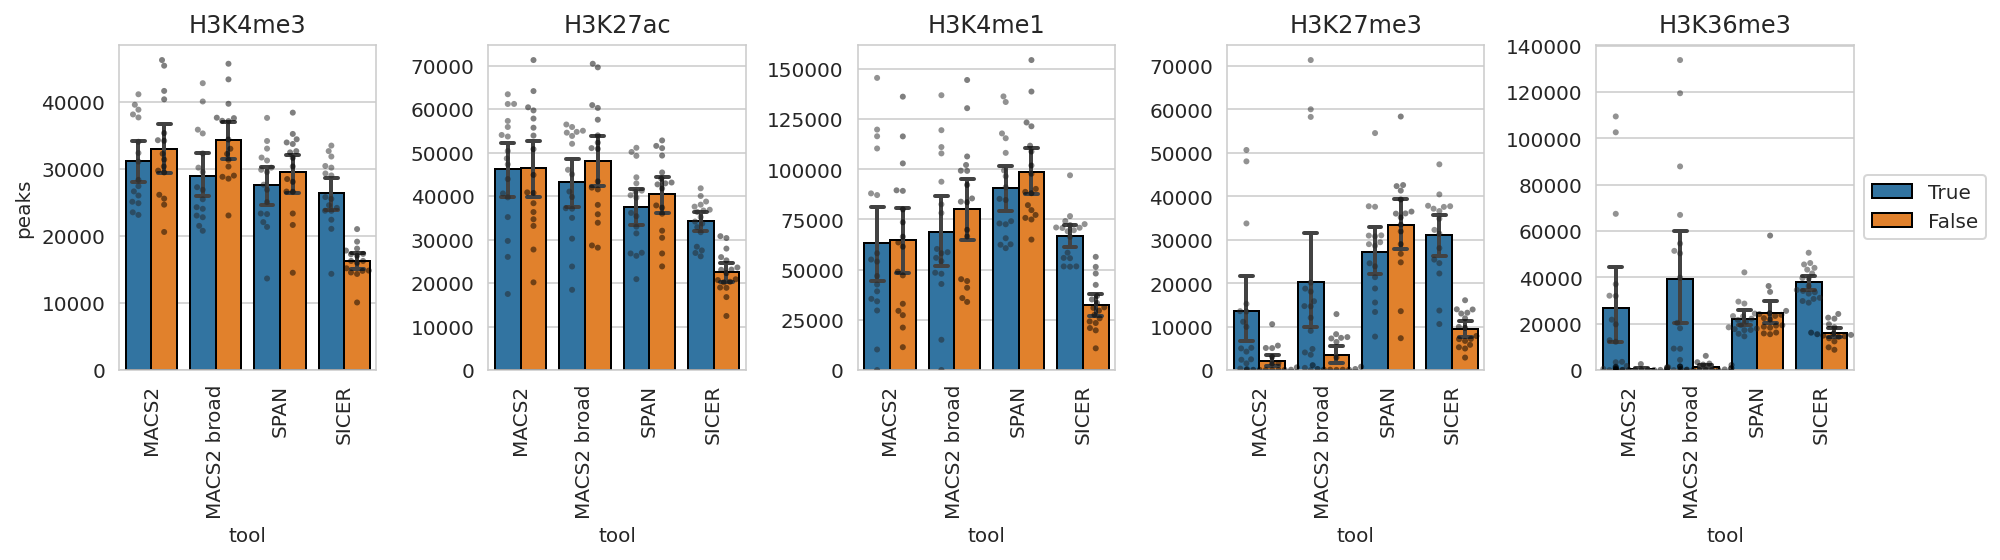

Roadmap


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette usin

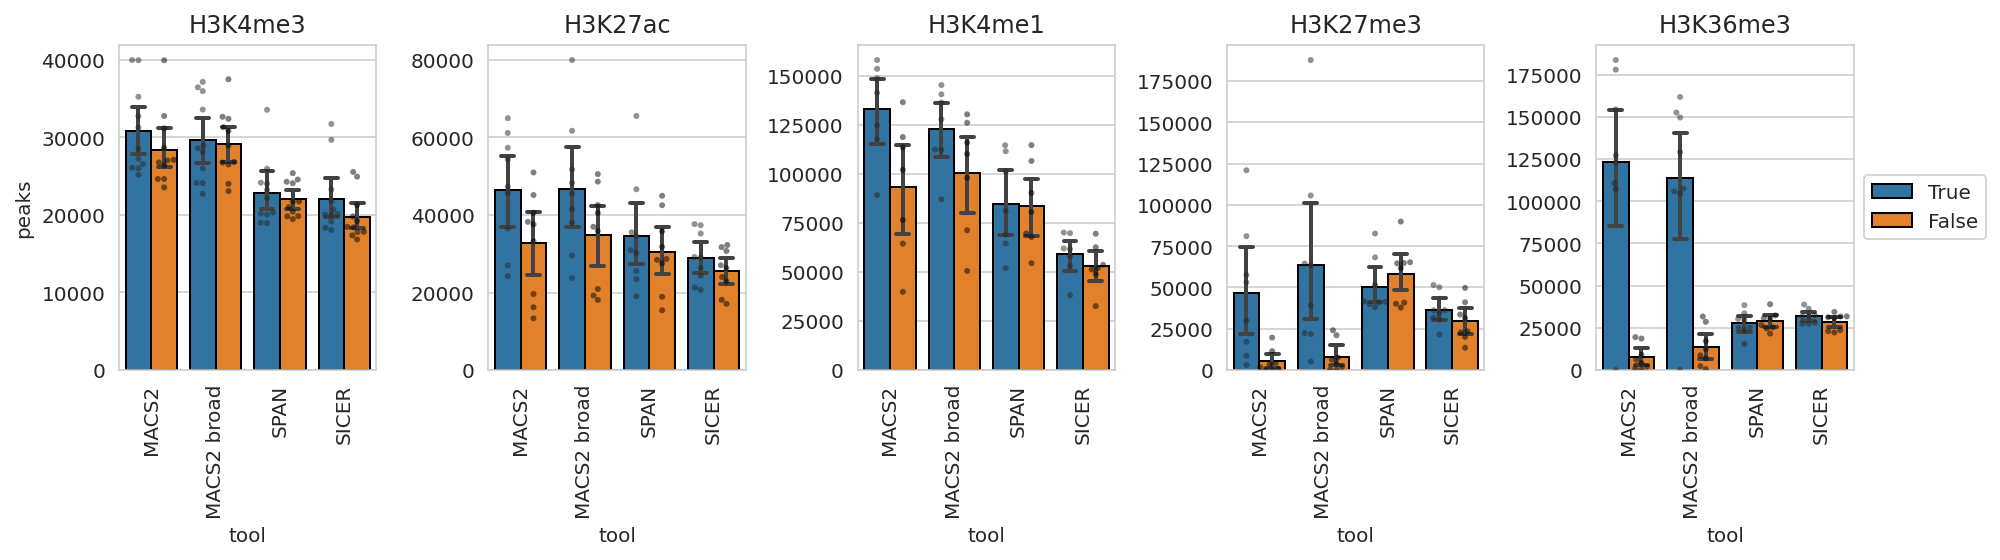

In [79]:
for ds in ['ENCODE', 'Roadmap']:
    print(ds)
    plt.figure(figsize=(14, 4))
    axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
    for i, m in enumerate(MODIFICATIONS):
        ax = axs[i]
        sns.barplot(data=df_peaks[(df_peaks['dataset'] == ds) & 
                                  (df_peaks['modification'] == m)], x='tool', y='peaks', hue='control',
                    capsize=.2, errwidth=2, edgecolor="black",
                    order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                    hue_order=[True, False],
                    ax=ax,)
        sns.swarmplot(data=df_peaks[(df_peaks['dataset'] == ds) &
                                    (df_peaks['modification'] == m)], x='tool', y='peaks', hue='control',
                      dodge=True, size=3, color="black", alpha=0.5,
                      order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'], legend=False,
                      hue_order=[True, False],
                      ax=ax)

        ax.xaxis.set_tick_params(rotation=90)
        ax.title.set_text(m)
        if i > 0:
            ax.set_ylabel(None)
        else:
            ax.set_ylabel('peaks')
        if i < 4:
            ax.legend().set_visible(False)
        else:
            # Put a legend to the right of the current axis
            ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

        # ax.set_ylim(0, 1.9e7)
    plt.tight_layout()
    # plt.savefig(GSE26320_PATH_HG38 + f'/pics/library_mapped_detailed_all.pdf', bbox_inches='tight', dpi=300)
    plt.show()

# Compute ratio no control vs control

In [41]:
rows = []
for (ds, m, c, r, t), dft in tqdm(df_peaks.groupby(['dataset', 'modification', 'cell', 'replicate', 'tool'])):
    if len(dft) == 2:
        with_control = dft[dft['control'] == True]['file'].values[0]
        without_control = dft[dft['control'] == False]['file'].values[0]
        peaks_with_control = lines(with_control)
        peaks_without_control = lines(without_control)
        rows.append((ds, m, c, r, t, d(peaks_without_control, peaks_with_control)))
df_ratio = pd.DataFrame(rows, columns=['dataset', 'modification', 'cell', 'replicate', 'tool', 'ratio'])
df_ratio['ratio'] = ((df_ratio['ratio'] - 1) * 100).astype(int)
del rows
df_ratio.sample(3)

  0%|          | 0/504 [00:00<?, ?it/s]

,dataset,modification,cell,replicate,tool,ratio
481,Roadmap,H3K4me3,CD4ABT,rep2,MACS2 broad,-20
147,ENCODE,H3K36me3,H1,rep2,SPAN,9
33,ENCODE,H3K27ac,HepG2,rep2,MACS2 broad,42


ENCODE


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


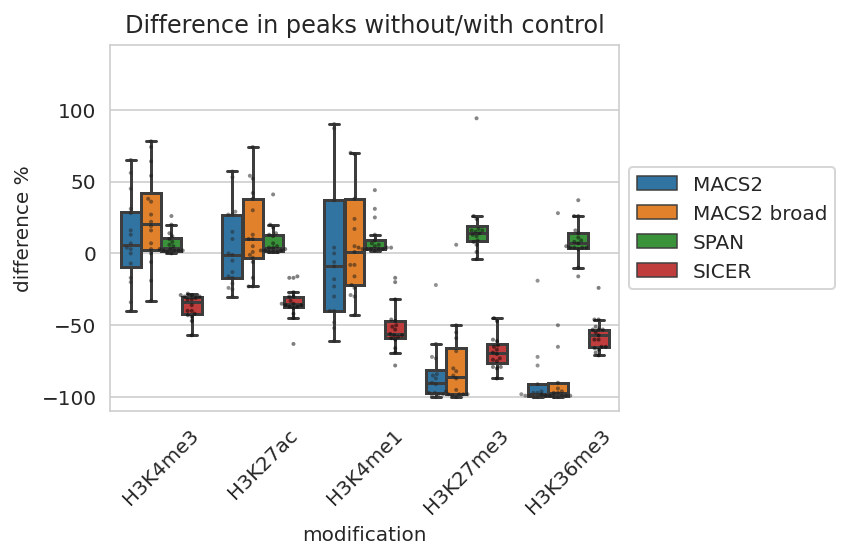

Roadmap


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


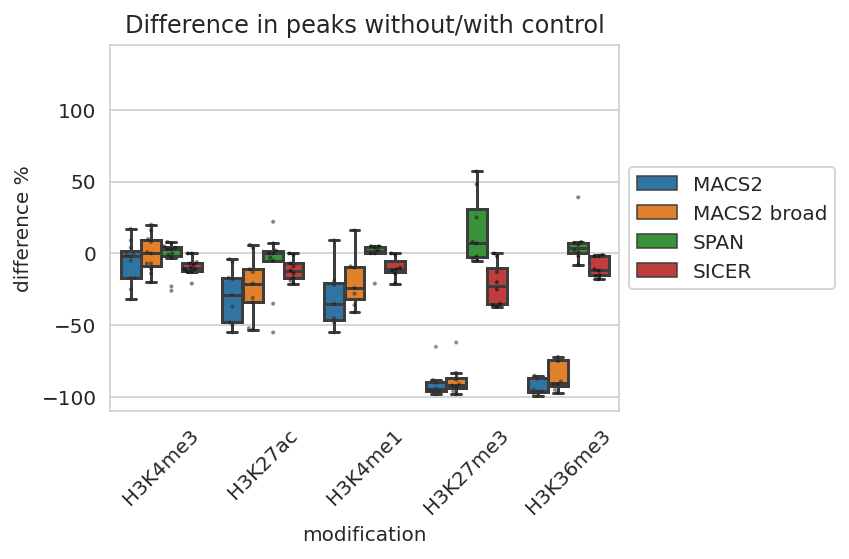

In [42]:
for ds in ['ENCODE', 'Roadmap']:
    print(ds)
    plt.figure(figsize=(6, 4))
    ax = plt.axes()
    sns.boxplot(data=df_ratio[df_ratio['dataset'] == ds],
                x='modification', y='ratio', hue='tool',
                showfliers=False,
                order=['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3'],
                hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                ax=ax)
    sns.swarmplot(data=df_ratio[df_ratio['dataset'] == ds],
                  x='modification', y='ratio', hue='tool',
                  dodge=True, size=2, color="black", alpha=0.5,
                  order=['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3'],
                  hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'], legend=False,
                  ax=ax)    
    ax.set_ylabel('difference %')
    ax.xaxis.set_tick_params(rotation=45)
    ax.set_ylim(-110, 145)
    ax.set_title('Difference in peaks without/with control')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    plt.show()

# Jaccard without control vs with control

In [12]:
tf = tempfile.mktemp()
rows = []
for (ds, m, c, r, t), dft in tqdm(df_peaks.groupby(['dataset', 'modification', 'cell', 'replicate', 'tool'])):
    if len(dft) == 2:
        with_control = sorted_file(dft[dft['control'] == True]['file'].values[0])
        without_control = sorted_file(dft[dft['control'] == False]['file'].values[0])
        peaks_with_control = lines(with_control)
        peaks_without_control = lines(without_control)
        len_with_control = bedl(with_control).sum()
        len_without_control = bedl(without_control).sum()
        !bedtools intersect -a {with_control} -b {without_control} -wo > {tf}
        overlap_len = int(last_col(tf).sum())
        jaccard = d(overlap_len, len_with_control + len_without_control - overlap_len)
        rows.append((ds, m, c, r, t, peaks_with_control, peaks_without_control, len_with_control, len_without_control, 
                     d(len_with_control, peaks_with_control), d(len_without_control, peaks_without_control),
                     overlap_len, jaccard))
df_jaccard = pd.DataFrame(rows, columns=['dataset', 'modification', 'cell', 'replicate', 'tool',
                                         'peaks_with_control', 'peaks_without_control',
                                         'len_with_control', 'len_without_control', 
                                         'avg_len_with_control', 'avg_len_without_control',
                                         'overlap_len', 'jaccard'])
del rows
df_jaccard.sample(3)

  0%|          | 0/504 [00:00<?, ?it/s]

,dataset,modification,cell,replicate,tool,peaks_with_control,peaks_without_control,len_with_control,len_without_control,avg_len_with_control,avg_len_without_control,overlap_len,jaccard
217,ENCODE,H3K4me1,HMEC,rep1,MACS2 broad,15099,106327,7524484.0,63932875,498.343202,601.285421,6802608,0.105214
375,Roadmap,H3K27me3,CD34,,SPAN,39818,37855,269803240.0,295547784,6775.911397,7807.364523,263451156,0.872644
31,ENCODE,H3K27ac,HepG2,rep1,SPAN,26891,30419,71976709.0,85886479,2676.609609,2823.448470,71828906,0.834887


ENCODE


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


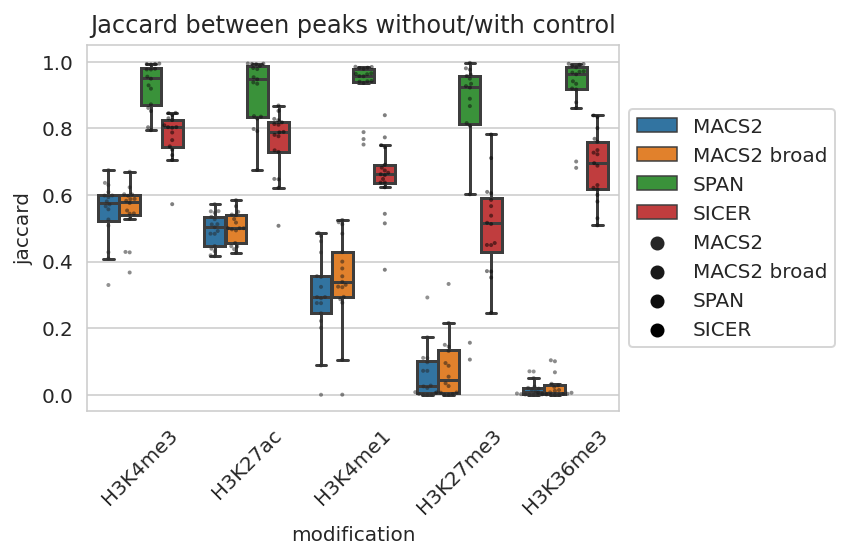

Roadmap


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


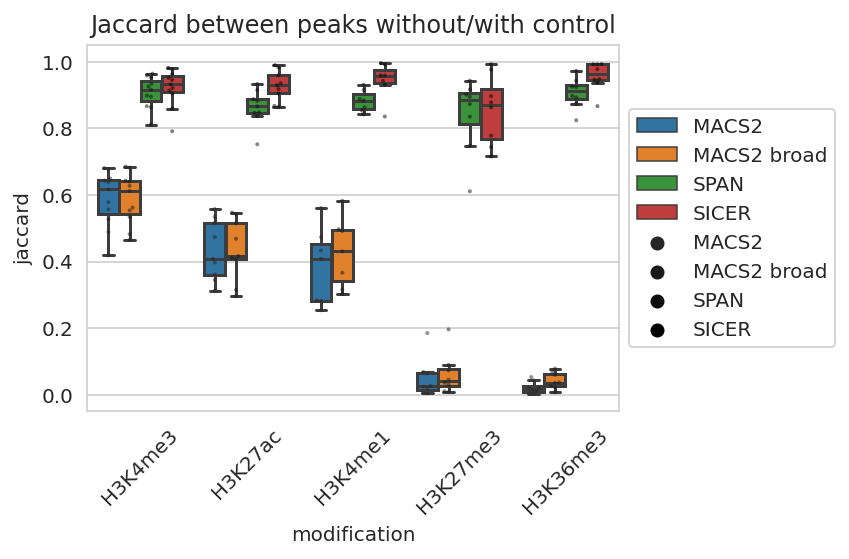

In [30]:
for ds in ['ENCODE', 'Roadmap']:
    print(ds)
    plt.figure(figsize=(6, 4))
    ax = plt.axes()
    sns.boxplot(data=df_jaccard[df_jaccard['dataset'] == ds],
                x='modification', y='jaccard', hue='tool',
                showfliers=False,
                order=['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3'],
                hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                ax=ax)
    sns.swarmplot(data=df_jaccard[df_jaccard['dataset'] == ds],
                  x='modification', y='jaccard', hue='tool',
                  dodge=True, size=2, color="black", alpha=0.5,
                  order=['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3'],
                  hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'], legend=False,
                  ax=ax)
    ax.set_ylabel('jaccard')
    ax.xaxis.set_tick_params(rotation=45)
    ax.set_ylim(-0.05, 1.05)
    ax.set_title('Jaccard between peaks without/with control')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    plt.show()

In [31]:
df_jaccard[(df_jaccard['dataset'] == 'Roadmap') & 
         (df_jaccard['modification'] == 'H3K27me3') & 
         (df_jaccard['jaccard'] < 0.2)]

,dataset,modification,cell,replicate,tool,peaks_with_control,peaks_without_control,len_with_control,len_without_control,avg_len_with_control,avg_len_without_control,overlap_len,jaccard,union_len,overlap_diff
368,Roadmap,H3K27me3,BCell,,MACS2,120947,11481,62817094.0,4307222,519.377033,375.160874,4064940,0.064462,63059376.0,58994436.0
369,Roadmap,H3K27me3,BCell,,MACS2 broad,187656,21098,115946312.0,8882313,617.866266,421.002607,8526993,0.073318,116301632.0,107774639.0
372,Roadmap,H3K27me3,CD34,,MACS2,53084,1819,29118068.0,594207,548.528144,326.666850,545712,0.018710,29166563.0,28620851.0
373,Roadmap,H3K27me3,CD34,,MACS2 broad,64451,3891,45059059.0,1455076,699.121177,373.959393,1383724,0.030661,45130411.0,43746687.0
376,Roadmap,H3K27me3,CD34,rep2,MACS2,81061,4321,70038383.0,1913425,864.020713,442.819949,1868617,0.026663,70083191.0,68214574.0
377,Roadmap,H3K27me3,CD34,rep2,MACS2 broad,105668,7535,105504627.0,3847627,998.453903,510.633975,3792270,0.035925,105559984.0,101767714.0
380,Roadmap,H3K27me3,CD4,,MACS2,3126,113,1004365.0,43409,321.293986,384.150442,4627,0.004436,1043147.0,1038520.0
381,Roadmap,H3K27me3,CD4,,MACS2 broad,5166,179,2053450.0,71059,397.493225,396.977654,23183,0.011033,2101326.0,2078143.0
384,Roadmap,H3K27me3,CD4,rep2,MACS2,8738,148,3386228.0,60751,387.528954,410.479730,18655,0.005441,3428324.0,3409669.0
385,Roadmap,H3K27me3,CD4,rep2,MACS2 broad,21849,387,9943058.0,155111,455.080690,400.803618,90950,0.009088,10007219.0,9916269.0


In [15]:
df_jaccard['union_len'] = df_jaccard['len_with_control'] + df_jaccard['len_without_control']  - df_jaccard['overlap_len']
df_jaccard['overlap_diff'] = df_jaccard['len_with_control'] + df_jaccard['len_without_control']  - 2 * df_jaccard['overlap_len']

ENCODE


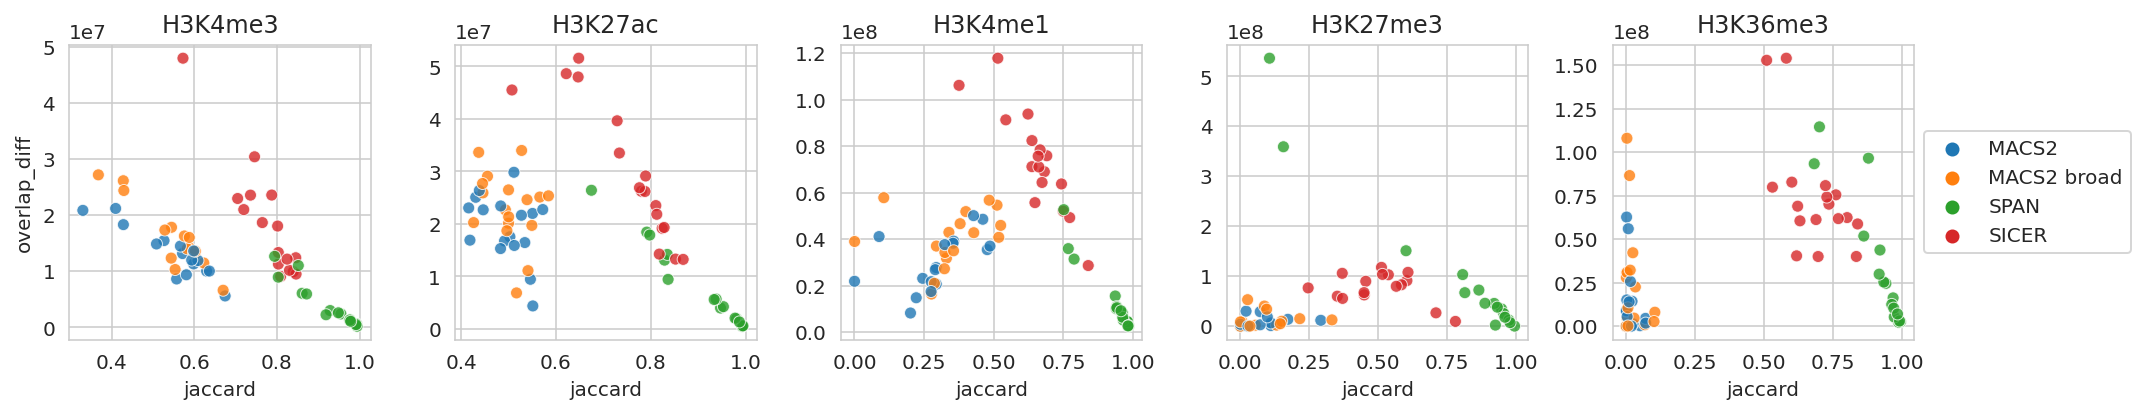

Roadmap


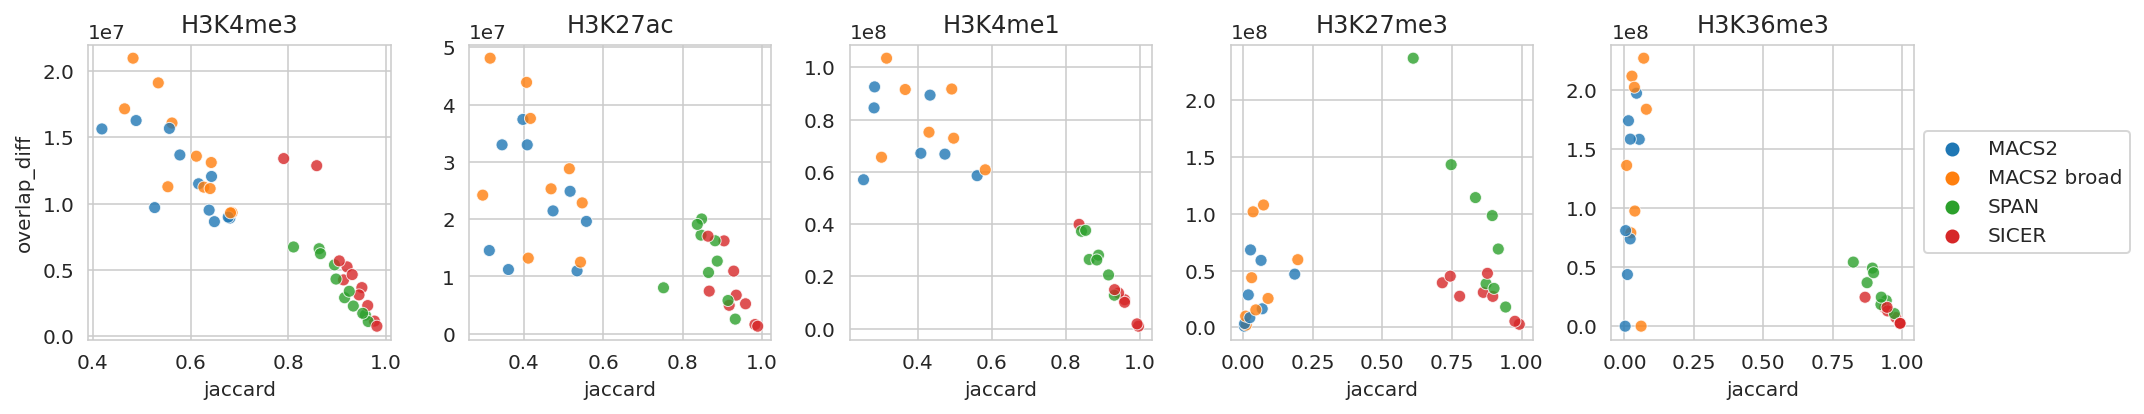

In [16]:
for ds in ['ENCODE', 'Roadmap']:
    print(ds)
    plt.figure(figsize=(15, 3))
    axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
    for i, m in enumerate(MODIFICATIONS):
        ax = axs[i]
        sns.scatterplot(df_jaccard[(df_jaccard['dataset'] == ds) &
                                   (df_jaccard['modification'] == m)],
                        palette=TOOLS_PALETTE,
                        hue_order=TOOLS,
                        x='jaccard', y='overlap_diff', hue='tool', alpha=0.8,
                        ax = ax)
        ax.set_title(m)
        if i > 0:
            ax.set_ylabel(None)
        if i < len(axs) - 1:
            ax.legend().set_visible(False)
        else:
            # Put a legend to the right of the current axis
            ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    plt.show()

In [17]:
rows = []
for _, (ds, modification, tool, jaccard, avlc, avlwc) in df_jaccard[
    ['dataset', 'modification', 'tool', 'jaccard', 'avg_len_with_control', 'avg_len_without_control']].iterrows():
    rows.append((ds, modification, tool, jaccard, avlc))
    rows.append((ds, modification, tool, jaccard, avlwc))
df_jaccard_avg_len = pd.DataFrame(rows, columns=['dataset', 'modification', 'tool', 'jaccard', 'average_len'])
del rows

ENCODE


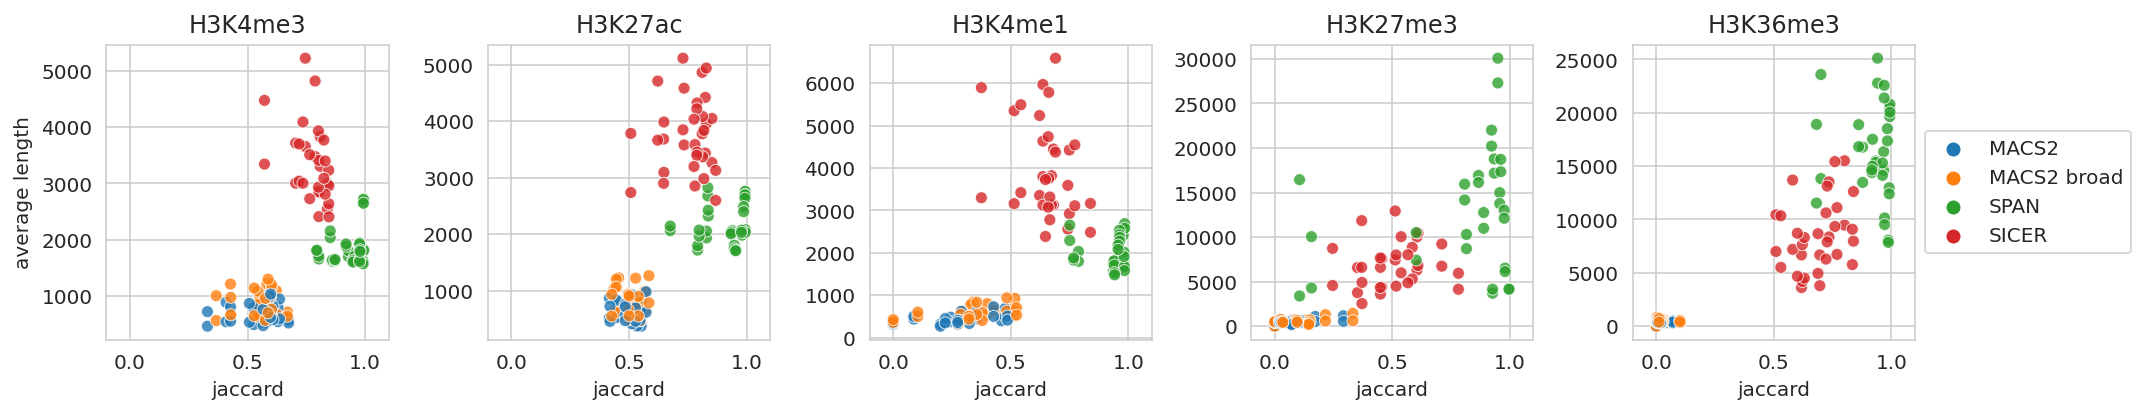

Roadmap


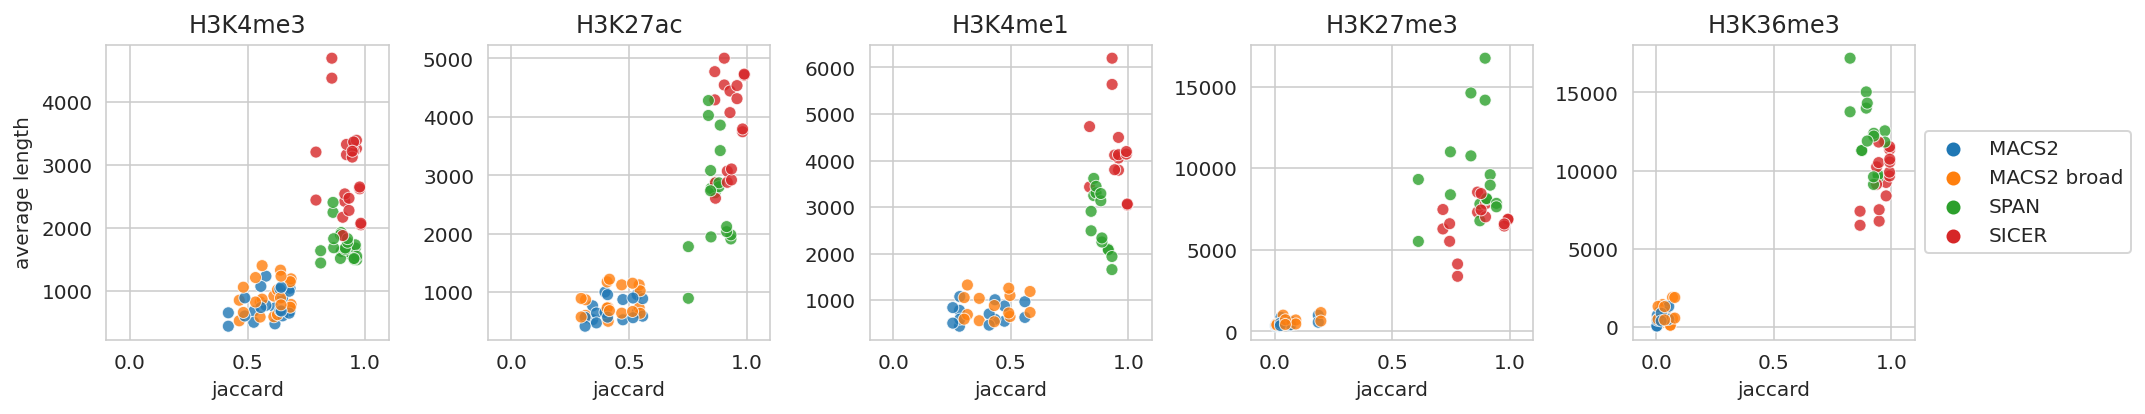

In [18]:
for ds in ['ENCODE', 'Roadmap']:
    print(ds)
    plt.figure(figsize=(15, 3))
    axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
    for i, m in enumerate(MODIFICATIONS):
        ax = axs[i]
        sns.scatterplot(
            df_jaccard_avg_len[(df_jaccard_avg_len['dataset'] == ds) &
                       (df_jaccard_avg_len['modification'] == m)],
            palette=TOOLS_PALETTE,
            hue_order=TOOLS,
            x='jaccard', y='average_len', hue='tool', alpha=0.8,
            ax = ax,
            # fill=True
        )
        ax.set_title(m)
        ax.set_xlim(-0.1, 1.1)
        ax.set_title(m)
        if i > 0:
            ax.set_ylabel(None)
        else:
            ax.set_ylabel('average length')
        if i < len(axs) - 1:
            ax.legend().set_visible(False)
        else:
            # Put a legend to the right of the current axis
            ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    plt.show()

In [19]:
# K27me3 outliers HepG2 rep1 and HMEC rep2
df_jaccard[(df_jaccard['dataset'] == 'ENCODE') & (df_jaccard['modification'] == 'H3K27me3') & (df_jaccard['tool']=='SPAN')]

,dataset,modification,cell,replicate,tool,peaks_with_control,peaks_without_control,len_with_control,len_without_control,avg_len_with_control,avg_len_without_control,overlap_len,jaccard,union_len,overlap_diff
71,ENCODE,H3K27me3,GM12878,rep2,SPAN,21369,24811,642764451.0,677327897,30079.294820,27299.500101,642764301,0.948970,677328047.0,34563746.0
75,ENCODE,H3K27me3,H1,rep1,SPAN,7709,7344,28551394.0,30491881,3703.644312,4151.944581,28396259,0.926559,30647016.0,2250757.0
79,ENCODE,H3K27me3,H1,rep2,SPAN,13353,13566,56156586.0,56325887,4205.540777,4151.989312,56137494,0.996318,56344979.0,207485.0
83,ENCODE,H3K27me3,HMEC,rep1,SPAN,37477,42603,561587037.0,586501043,14984.845025,13766.660634,561418133,0.956957,586669947.0,25251814.0
87,ENCODE,H3K27me3,HMEC,rep2,SPAN,15523,42359,66602944.0,425836883,4290.597436,10053.043816,66592621,0.156377,425847206.0,359254585.0
91,ENCODE,H3K27me3,HSMM,rep1,SPAN,28948,36027,461666065.0,510340318,15948.116105,14165.495823,434307172,0.807714,537699211.0,103392039.0
95,ENCODE,H3K27me3,HSMM,rep2,SPAN,37548,41319,488880872.0,500583596,13020.157452,12115.094654,488712853,0.975959,500751615.0,12038762.0
99,ENCODE,H3K27me3,HepG2,rep1,SPAN,18708,36494,63500509.0,600018917,3394.297039,16441.577163,63499906,0.105830,600019520.0,536519614.0
103,ENCODE,H3K27me3,HepG2,rep2,SPAN,24559,28991,540437196.0,585929846,22005.667820,20210.749750,540373590,0.922150,585993452.0,45619862.0
107,ENCODE,H3K27me3,Huvec,rep1,SPAN,30740,35152,392295491.0,386264144,12761.727098,10988.397360,366324962,0.888632,412234673.0,45909711.0


In [20]:
# for ds, m in product(['ENCODE', 'Roadmap'], ['H3K4me3', 'H3K36me3']):
#     print(ds, m)
#     plt.figure(figsize=(5, 3))
#     ax = plt.axes()
#     # sns.kdeplot(
#         
#     sns.scatterplot(
#         df_jaccard[(df_jaccard['dataset'] == ds) &
#                                (df_jaccard['modification'] == m)],
#                     palette=TOOLS_PALETTE,
#                     hue_order=TOOLS,
#                     x='jaccard', y='avg_len_with_control', hue='tool', alpha=0.8,
#                     ax = ax,
#     # fill=True
#     )
#     ax.set_title(m)
#     ax.set_xlim(-0.1, 1.1)
#     ax.set_ylabel('average length')
#     # Put a legend to the right of the current axis
#     ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#     plt.tight_layout()
#     plt.show()

In [21]:
# for ds, m in product(['ENCODE', 'Roadmap'], ['H3K4me3', 'H3K36me3']):
#     print(ds, m)
#     plt.figure(figsize=(5, 3))
#     ax = plt.axes()
#     sns.scatterplot(df_jaccard[(df_jaccard['dataset'] == ds) &
#                                (df_jaccard['modification'] == m)],
#                     palette=TOOLS_PALETTE,
#                     hue_order=TOOLS,
#                     x='avg_len_with_control', y='avg_len_without_control', hue='tool', alpha=0.8,
#                     ax = ax)
#     ax.set_title(m)
#     # Put a legend to the right of the current axis
#     ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#     plt.tight_layout()
#     plt.show()

# Load BAMS

In [43]:
def load_bams(path, modifications, cells, replicates, control='Input'):
    df_bams = pd.DataFrame(columns=['bam_file', 'modification', 'cell', 'replicate', 'reads'], dtype=object)
    for f in tqdm(os.listdir(path)):
        if not f.endswith('.bam'):
            continue
        cell = next((c for c in cells if c in f), None)
        rep = next((r for r in replicates if r in f), None)
        mod = next((m for m in modifications if m in f), None)
        if mod is None and control is not None and control in f:
            mod = 'Control'
        if cell and mod and rep is not None:
            file = os.path.join(path, f)
            reads = ! samtools view -F 0x04 -c {file}
            reads = int(reads[0])
            df_bams.loc[len(df_bams)] = (file, mod, cell, rep, reads)
    return df_bams

In [ ]:
df_encode_bams = load_bams(GSE26320_PATH + '/bams', MODIFICATIONS, GSE26320_CELLS, GSE26320_REPS, 'Input')
df_encode_bams['dataset'] = 'ENCODE'
df_immune_bams = load_bams(IMMUNE_PATH + '/bams', MODIFICATIONS, IMMUNE_CELLS, IMMUNE_REPS, 'Control')
df_immune_bams['dataset'] = 'Roadmap'

df_bams = pd.concat([df_encode_bams, df_immune_bams]).reset_index(drop=True)


In [ ]:
plt.figure(figsize=(6, 4))
ax = plt.axes()
sns.barplot(data=df_bams, hue='modification', x='dataset', y='reads',
            capsize=.05, errwidth=2, edgecolor="black",
            hue_order=MODIFICATIONS + ['Control'],
            ax=ax)
sns.swarmplot(data=df_bams, hue='modification', x='dataset', y='reads',
              dodge=True, size=3, palette='dark:black', alpha=0.5, legend=False,
              hue_order=MODIFICATIONS + ['Control'],
              ax=ax)
ax.set_title('Library size')
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

# Compare peaks diff between replicates

In [96]:
def compute_reps_peaks(df_peaks, modifications, cells):
    rows = []
    t = df_peaks[(df_peaks['modification'].isin(modifications)) & (df_peaks['cell'].isin(cells))]
    for (ds, m, c, to), group in t.groupby(['dataset', 'modification', 'cell', 'tool']):
        if len(group) != 2:
            continue
        group.sort_values(by='replicate', inplace=True)
        rep1, rep2 = group['replicate'].values[0], group['replicate'].values[1]
        peaks1, peaks2 = group['peaks'].values[0], group['peaks'].values[1]
        rows.append((ds, m, c, to, rep1, rep2, peaks1, peaks2))
    return pd.DataFrame(rows, columns=['dataset', 'modification', 'cell', 'tool', 'replicate1', 'replicate2', 'peaks1', 'peaks2'])

In [103]:
df_peaks_original = df_peaks[(df_peaks['dataset']=='ENCODE') & (df_peaks['control']==True)].copy()

In [104]:
df_encode_reps = compute_reps_peaks(df_peaks_original, MODIFICATIONS, GSE26320_CELLS)
df_encode_reps.sample(5)

,dataset,modification,cell,tool,replicate1,replicate2,peaks1,peaks2
72,ENCODE,H3K36me3,HSMM,MACS2,rep1,rep2,529,12203
68,ENCODE,H3K36me3,HMEC,MACS2,rep1,rep2,0,109427
119,ENCODE,H3K4me1,NHEK,SPAN,rep1,rep2,108123,117793
42,ENCODE,H3K27me3,HSMM,SICER,rep1,rep2,25434,37162
38,ENCODE,H3K27me3,HMEC,SICER,rep1,rep2,37575,22244


# SWAP controls

In [48]:
# Swap controls in replicates
SWAP_CONTROL_DIR = os.path.expanduser('~/data/2024_swap_control')
! mkdir -p {SWAP_CONTROL_DIR}/bams

In [50]:
rows = []
for (ds, m, c), group in tqdm(
        df_bams[(df_bams['modification'] != 'Control')].groupby(['dataset', 'modification', 'cell'])):
    if len(group) != 2:
        continue
    file1, file2 = group['bam_file'].values[0], group['bam_file'].values[1]
    r1, r2 = group['replicate'].values[0], group['replicate'].values[1]
    cr1 = r1
    # Find control1
    ct = df_bams[(df_bams['modification'] == 'Control') & (df_bams['cell'] == c) &
                 (df_bams['replicate'] == cr1) & (df_bams['dataset'] == ds)]
    if len(ct) == 0:  # Control can be different for Roadmap
        cr1 = ''
        ct = df_bams[(df_bams['modification'] == 'Control') & (df_bams['cell'] == c) &
                     (df_bams['replicate'] == cr1) & (df_bams['dataset'] == ds)]
    if len(ct) == 0:
        continue
    control1 = ct['bam_file'].values[0]
    # Find control1
    cr2 = r2
    ct = df_bams[(df_bams['modification'] == 'Control') & (df_bams['cell'] == c) &
                 (df_bams['replicate'] == cr2) & (df_bams['dataset'] == ds)]
    if len(ct) == 0:  # Control can be different for Roadmap
        cr2 = ''
        ct = df_bams[(df_bams['modification'] == 'Control') & (df_bams['cell'] == c) &
                     (df_bams['replicate'] == cr2) & (df_bams['dataset'] == ds)]
    if len(ct) == 0:
        continue
    control2 = ct['bam_file'].values[0]
    if control1 == control2:
        continue  # Ignore same control for replicates
    rows.append((ds, m, c, r1, file1, cr1, control1, r2, file2, cr2, control2))
df_controls = pd.DataFrame(rows, columns=['dataset', 'modification', 'cell',
                                          'replicate1', 'file1', 'control_replicate1', 'control_file1',
                                          'replicate2', 'file2', 'control_replicate2', 'control_file2'])
df_controls.sample(5)

In [ ]:
for _, (ds, m, c, r1, file1, cr1, control1, r2, file2, cr2, control2) in df_controls[
    ['dataset', 'modification', 'cell',
     'replicate1', 'file1', 'control_replicate1', 'control_file1',
     'replicate2', 'file2', 'control_replicate2', 'control_file2']].iterrows():
    print(ds, m, c)
    print(r1, file1, cr1, control1)
    print(r2, file2, cr2, control2)

    # Keep same signal
    ! ln -sf {file1} {SWAP_CONTROL_DIR}/bams/{ds}_{m}_{c}_{r1}.bam
    ! ln -sf {file2} {SWAP_CONTROL_DIR}/bams/{ds}_{m}_{c}_{r2}.bam
    # Swap controls
    ! ln -sf {control1} {SWAP_CONTROL_DIR}/bams/{ds}_Control_{c}_{r2}_swap.bam
    ! ln -sf {control2} {SWAP_CONTROL_DIR}/bams/{ds}_Control_{c}_{r1}_swap.bam

## Peak calling and visualization

```
conda activate snakemake
snakemake -p -s ~/work/chipseq-smk-pipeline/Snakefile all --cores all  --use-conda  --directory $(pwd) --config genome=hg38 fastq_dir=$(pwd) start_with_bams=True bams_dir=bams bamCoverage_params="--ignoreDuplicates" macs2=True --rerun-trigger mtime;
snakemake -p -s ~/work/chipseq-smk-pipeline/Snakefile all --cores all  --use-conda  --directory $(pwd) --config genome=hg38 fastq_dir=$(pwd) start_with_bams=True bams_dir=bams bamCoverage_params="--ignoreDuplicates" macs2=True macs2_mode=broad macs2_params="--broad --broad-cutoff=0.1" macs2_suffix="broad0.1"  --rerun-trigger mtime; 
snakemake -p -s ~/work/chipseq-smk-pipeline/Snakefile all --cores all  --use-conda  --directory $(pwd) --config genome=hg38 fastq_dir=$(pwd) start_with_bams=True bams_dir=bams bamCoverage_params="--ignoreDuplicates" span=True sicer=True span_bin=200 span_gap=0 --rerun-trigger mtime; 

```

  0%|          | 0/656 [00:00<?, ?it/s]

MACS2 82


  0%|          | 0/656 [00:00<?, ?it/s]

MACS2 broad 82


  0%|          | 0/82 [00:00<?, ?it/s]

SICER 82


  0%|          | 0/185 [00:00<?, ?it/s]

SPAN 82


/tmp/ipykernel_522188/3518377940.py:15: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(data=df_swapped[df_swapped['modification'] == m], x='tool', y='peaks',
/tmp/ipykernel_522188/3518377940.py:15: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(data=df_swapped[df_swapped['modification'] == m], x='tool', y='peaks',
/tmp/ipykernel_522188/3518377940.py:15: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(data=df_swapped[df_swapped['modification'] == m], x='tool', y='peaks',
/tmp/ipykernel_522188/3518377940.py:15: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(data=df_swapped[df_swapped['modification'] == m], x='tool', y='peaks',
/tmp/ipykernel_522188/3518377940.py:15: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(data=df_swapped[df_swapped['modification'] == m], x='tool', y='peaks',


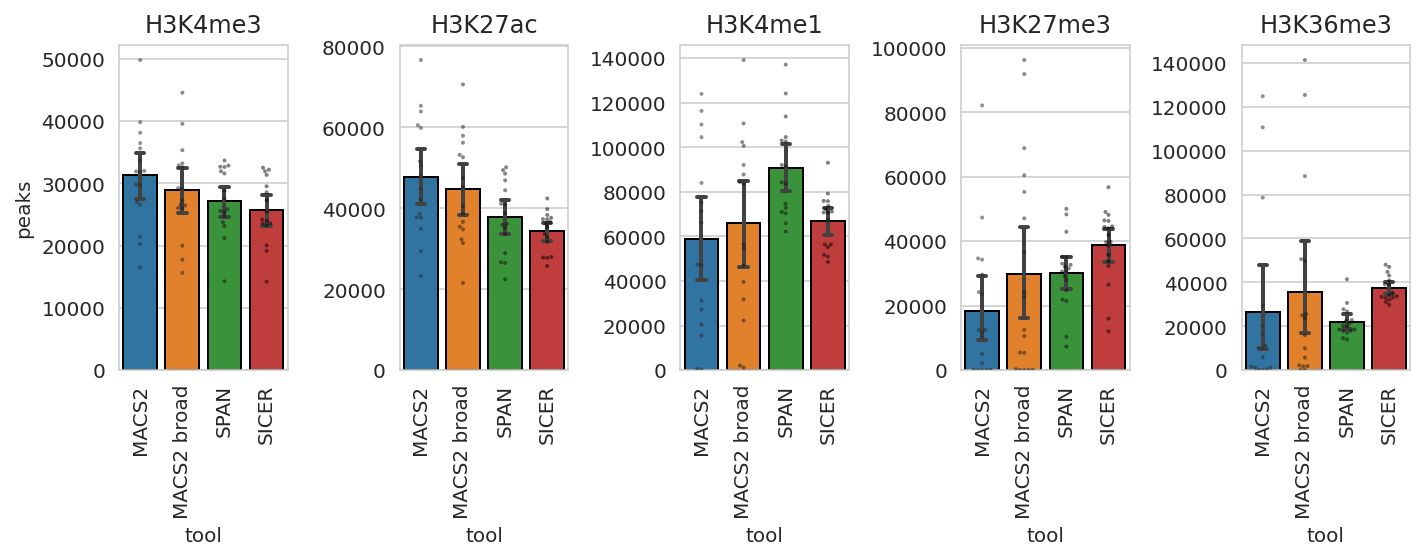

In [82]:
df_swapped = load_peaks_path(SWAP_CONTROL_DIR, MODIFICATIONS, GSE26320_CELLS + IMMUNE_CELLS,
                             GSE26320_REPS + IMMUNE_REPS)
df_swapped['dataset'] = ['ENCODE' if 'ENCODE' in f else 'Roadmap' for f in df_swapped['file']]
df_swapped.sample(5)
plt.figure(figsize=(10, 4))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, m in enumerate(MODIFICATIONS):
    ax = axs[i]
    sns.barplot(data=df_swapped[df_swapped['modification'] == m], x='tool', y='peaks',
                # showfliers=False,
                capsize=.2, errwidth=2, edgecolor="black",
                palette=TOOLS_PALETTE,
                order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                ax=ax)
    sns.swarmplot(data=df_swapped[df_swapped['modification'] == m], x='tool', y='peaks',
                  size=2, palette='dark:black', alpha=0.5,
                  order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'], legend=False,
                  ax=ax)
    ax.xaxis.set_tick_params(rotation=90)
    ax.title.set_text(m)
    if i > 0:
        ax.set_ylabel(None)
    # ax.set_ylim(0, 1)
plt.tight_layout()
# plt.savefig(GSE26320_PATH_HG38 + f'/pics/library_mapped_detailed_all.pdf', bbox_inches='tight', dpi=300)
plt.show()

In [98]:
df_swapped_reps = compute_reps_peaks(df_swapped, MODIFICATIONS, GSE26320_CELLS + IMMUNE_CELLS)
df_swapped_reps['reps_peaks_diff'] = np.fabs((df_swapped_reps['peaks1'] - df_swapped_reps['peaks2']) /
                                             (df_swapped_reps['peaks1'] + df_swapped_reps['peaks2']))
df_swapped_reps.sample(5)

,dataset,modification,cell,tool,replicate1,replicate2,peaks1,peaks2,reps_peaks_diff
38,ENCODE,H3K27me3,H1,SICER,rep1,rep2,12040,15955,0.139846
138,ENCODE,H3K4me3,H1,SICER,rep1,rep2,24179,23552,0.013136
105,ENCODE,H3K4me1,H1,MACS2 broad,rep1,rep2,1162,46991,0.951737
60,ENCODE,H3K27me3,NHEK,MACS2,rep1,rep2,34251,47324,0.160257
137,ENCODE,H3K4me3,H1,MACS2 broad,rep1,rep2,25994,26049,0.001057


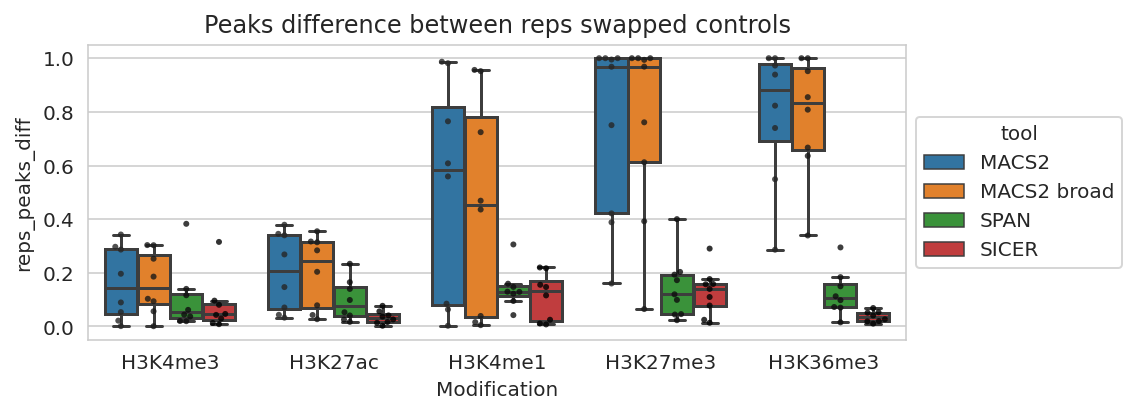

In [99]:
plt.figure(figsize=(8, 3))
ax = plt.axes()
sns.boxplot(data=df_swapped_reps, x='modification', hue='tool', y='reps_peaks_diff',
            palette=TOOLS_PALETTE,
            order=MODIFICATIONS,
            hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
            showfliers=False,
            ax=ax)
sns.swarmplot(data=df_swapped_reps, x='modification', hue='tool', y='reps_peaks_diff',
              dodge=True, size=3, palette='dark:black', alpha=0.8,
              order=MODIFICATIONS,
              hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'], legend=False,
              ax=ax)
ax.set_title('Peaks difference between reps swapped controls')
# ax.set_ylabel('Peaks difference')
ax.set_xlabel('Modification')
sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

MACS2


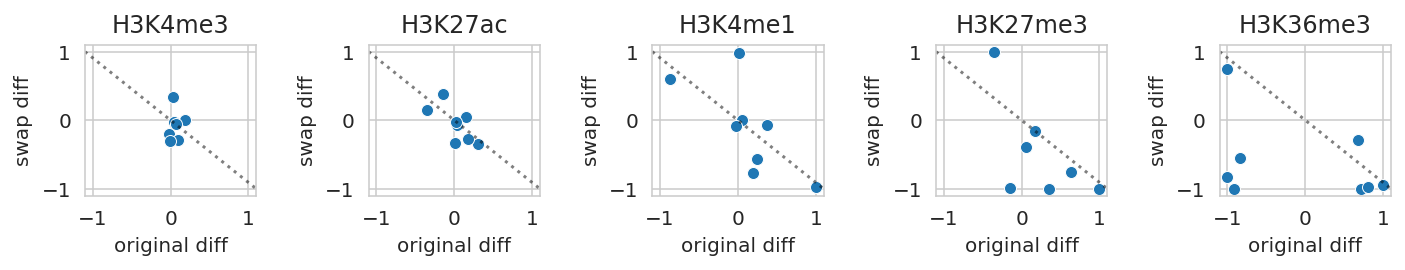

MACS2 broad


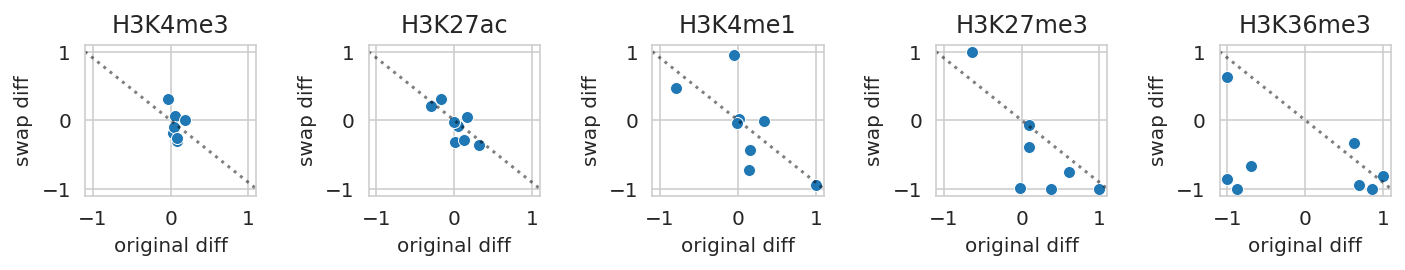

SPAN


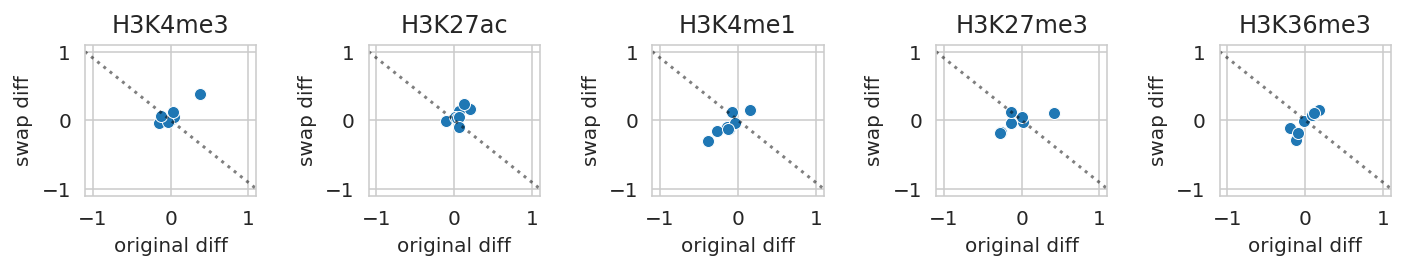

SICER


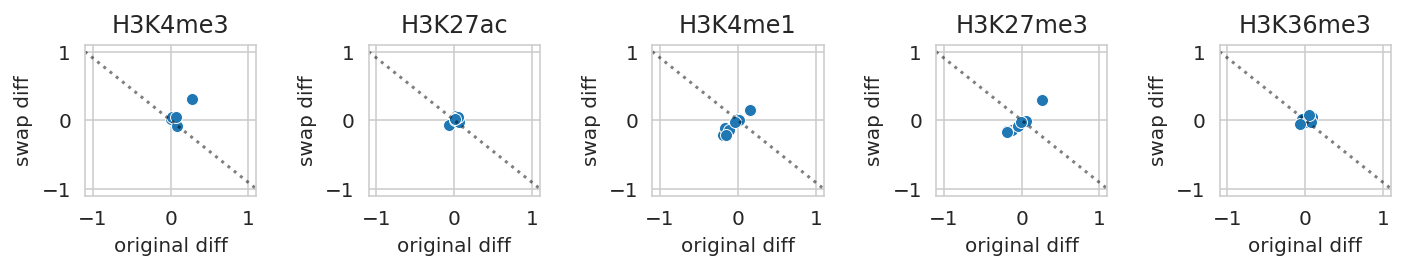

In [101]:
df_swapped_reps['swapped_reps_peaks_diff'] = \
    (df_swapped_reps['peaks1'] - df_swapped_reps['peaks2']) / (df_swapped_reps['peaks1'] + df_swapped_reps['peaks2'])
df_encode_reps['original_reps_peaks_diff'] = \
    (df_encode_reps['peaks1'] - df_encode_reps['peaks2']) / (df_encode_reps['peaks1'] + df_encode_reps['peaks2'])
t = pd.merge(df_swapped_reps, df_encode_reps, on=['modification', 'cell', 'tool', 'replicate1', 'replicate2'])

for tool in TOOLS:
    print(tool)
    plt.figure(figsize=(10, 2))
    axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
    for i, m in enumerate(MODIFICATIONS):
        ax = axs[i]
        tt = t[(t['modification'] == m) & (t['tool'] == tool)]
        sns.scatterplot(
            tt, x='original_reps_peaks_diff', y='swapped_reps_peaks_diff',
            ax=ax)
        sns.lineplot(x=[-1.1, 1.1], y=[1.0, -1.0], color='black', ax=ax, alpha=0.5, linestyle='dotted')
        ax.title.set_text(m)
        ax.set_xlabel('original diff')
        ax.set_ylabel('swap diff')
        ax.set_xlim(-1.1, 1.1)
        ax.set_ylim(-1.1, 1.1)
    plt.tight_layout()
    plt.show()

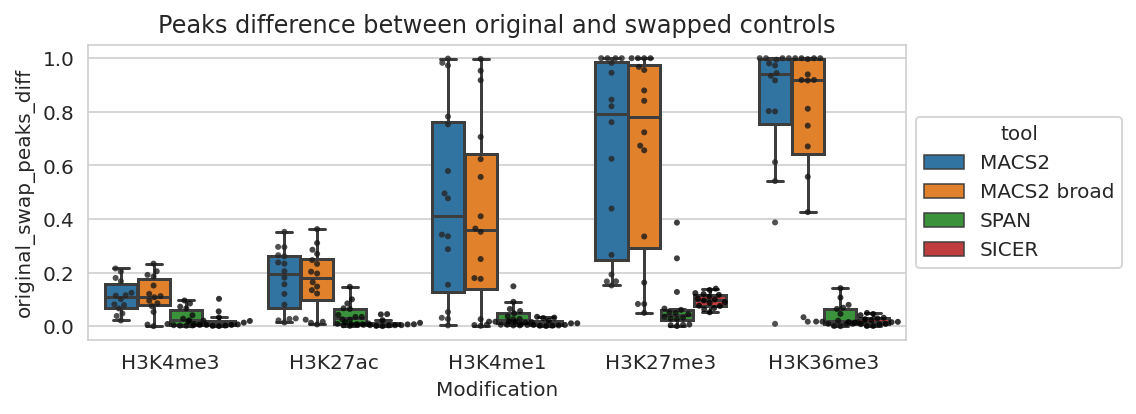

In [105]:
t = pd.merge(df_swapped[df_swapped['dataset'] == 'ENCODE'],
             df_peaks_original[['file', 'modification', 'cell', 'replicate', 'peaks', 'tool']],
             on=['modification', 'cell', 'replicate', 'tool'],
             suffixes=('_swapped', '_original'),
             how='inner')
t['original_swap_peaks_diff'] = [math.fabs(p1 - p2) / (p1 + p2) for _, (p1, p2) in
                                 t[['peaks_original', 'peaks_swapped']].iterrows()]

plt.figure(figsize=(8, 3))
ax = plt.axes()
sns.boxplot(data=t, x='modification', hue='tool', y='original_swap_peaks_diff',
            palette=TOOLS_PALETTE,
            order=MODIFICATIONS,
            hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
            showfliers=False,
            ax=ax)
sns.swarmplot(data=t, x='modification', hue='tool', y='original_swap_peaks_diff',
              dodge=True, size=3, palette='dark:black', alpha=0.8,
              order=MODIFICATIONS,
              hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'], legend=False,
              ax=ax)
ax.set_title('Peaks difference between original and swapped controls')
# ax.set_ylabel('Peaks difference')
ax.set_xlabel('Modification')
sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

# Minimal control size for replicates

In [107]:
SAME_REPLICATE_CONTROL_SIZE_DIR = os.path.expanduser('~/data/2024_same_replicate_control_size')
! mkdir -p {SAME_REPLICATE_CONTROL_SIZE_DIR}/bams

In [ ]:
tf = tempfile.mktemp()

for _, (ds, m, c, r1, file1, cr1, control1, r2, file2, cr2, control2) in df_controls[
    ['dataset', 'modification', 'cell',
     'replicate1', 'file1', 'control_replicate1', 'control_file1',
     'replicate2', 'file2', 'control_replicate2', 'control_file2']].iterrows():
    control1_reads = df_bams[(df_bams['dataset'] == ds) &
                             (df_bams['modification'] == 'Control') &
                             (df_bams['cell'] == c) &
                             (df_bams['replicate'] == cr1)]['reads'].values[0]
    control2_reads = df_bams[(df_bams['dataset'] == ds) &
                             (df_bams['modification'] == 'Control') &
                             (df_bams['cell'] == c) &
                             (df_bams['replicate'] == cr2)]['reads'].values[0]

    print(ds, m, c)
    print(r1, file1, cr1, control1, control1_reads)
    print(r2, file2, cr2, control2, control2_reads)
    # Keep same signal
    ! ln -sf {file1} {SAME_REPLICATE_CONTROL_SIZE_DIR}/bams/{ds}_{m}_{c}_{r1}.bam
    ! ln -sf {file2} {SAME_REPLICATE_CONTROL_SIZE_DIR}/bams/{ds}_{m}_{c}_{r2}.bam

    control_min_reads = min(control1_reads, control2_reads)
    mln_reads = int(control_min_reads / 1e6)
    for (r, cfile, creads) in [(r1, control1, control1_reads), (r2, control2, control2_reads)]:
        print(f'Processing {r} {cfile} {creads}')
        ds_cfile = f'{SAME_REPLICATE_CONTROL_SIZE_DIR}/bams/{ds}_Control_{c}_{r}_{mln_reads}M_of_{int(creads / 1e6)}M.bam'
        print(ds_cfile)
        if not os.path.exists(ds_cfile):
            if creads <= mln_reads:
                ! ln -sf {cfile} {ds_cfile}
            else:
                print(f'Downsampling {cfile}')
                fraction = control_min_reads / creads
                ! samtools view -@ 4 -H {cfile} > {tf}.sam
                ! samtools view -@ 4 -s {fraction} {cfile} >> {tf}.sam
                ! samtools view -S -b {tf}.sam > {tf}.bam
                ! samtools sort {tf}.bam -o {ds_cfile}
                ! rm {tf}.sam {tf}.bam    

## Peak calling and visualization

```
conda activate snakemake
snakemake -p -s ~/work/chipseq-smk-pipeline/Snakefile all --cores all  --use-conda  --directory $(pwd) --config genome=hg38 fastq_dir=$(pwd) start_with_bams=True bams_dir=bams bamCoverage_params="--ignoreDuplicates" macs2=True --rerun-trigger mtime;
snakemake -p -s ~/work/chipseq-smk-pipeline/Snakefile all --cores all  --use-conda  --directory $(pwd) --config genome=hg38 fastq_dir=$(pwd) start_with_bams=True bams_dir=bams bamCoverage_params="--ignoreDuplicates" macs2=True macs2_mode=broad macs2_params="--broad --broad-cutoff=0.1" macs2_suffix="broad0.1"  --rerun-trigger mtime; 
snakemake -p -s ~/work/chipseq-smk-pipeline/Snakefile all --cores all  --use-conda  --directory $(pwd) --config genome=hg38 fastq_dir=$(pwd) start_with_bams=True bams_dir=bams bamCoverage_params="--ignoreDuplicates" span=True sicer=True span_bin=200 span_gap=0 --rerun-trigger mtime; 

```

In [108]:
df_aligned_control = load_peaks_path(SAME_REPLICATE_CONTROL_SIZE_DIR, MODIFICATIONS, GSE26320_CELLS + IMMUNE_CELLS,
                                     GSE26320_REPS + IMMUNE_REPS)
df_aligned_control['dataset'] = ['ENCODE' if 'ENCODE' in f else 'Roadmap' for f in df_aligned_control['file']]
df_aligned_control.sample(5)

  0%|          | 0/656 [00:00<?, ?it/s]

MACS2 82


  0%|          | 0/656 [00:00<?, ?it/s]

MACS2 broad 82


  0%|          | 0/82 [00:00<?, ?it/s]

SICER 82


  0%|          | 0/185 [00:00<?, ?it/s]

SPAN 82


,file,modification,cell,replicate,peaks,tool,dataset
147,/home/jetbrains/data/2024_same_replicate_contr...,H3K4me3,Huvec,rep2,22807,MACS2 broad,ENCODE
326,/home/jetbrains/data/2024_same_replicate_contr...,H3K27ac,NHEK,rep1,50232,SPAN,ENCODE
4,/home/jetbrains/data/2024_same_replicate_contr...,H3K27ac,HMEC,rep2,32945,MACS2,ENCODE
226,/home/jetbrains/data/2024_same_replicate_contr...,H3K4me1,NHLF,rep2,69276,SICER,ENCODE
251,/home/jetbrains/data/2024_same_replicate_contr...,H3K27me3,HSMM,rep2,37722,SPAN,ENCODE


/tmp/ipykernel_522188/4103802102.py:11: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(data=df_aligned_control[df_aligned_control['modification'] == m], x='tool', y='peaks',
/tmp/ipykernel_522188/4103802102.py:11: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(data=df_aligned_control[df_aligned_control['modification'] == m], x='tool', y='peaks',
/tmp/ipykernel_522188/4103802102.py:11: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(data=df_aligned_control[df_aligned_control['modification'] == m], x='tool', y='peaks',
/tmp/ipykernel_522188/4103802102.py:11: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(data=df_aligned_control[df_aligned_control['modification'] == m], x='tool', y='peaks',
/tmp/ipykernel_522188/4103802102.py:11: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(data=df_alig

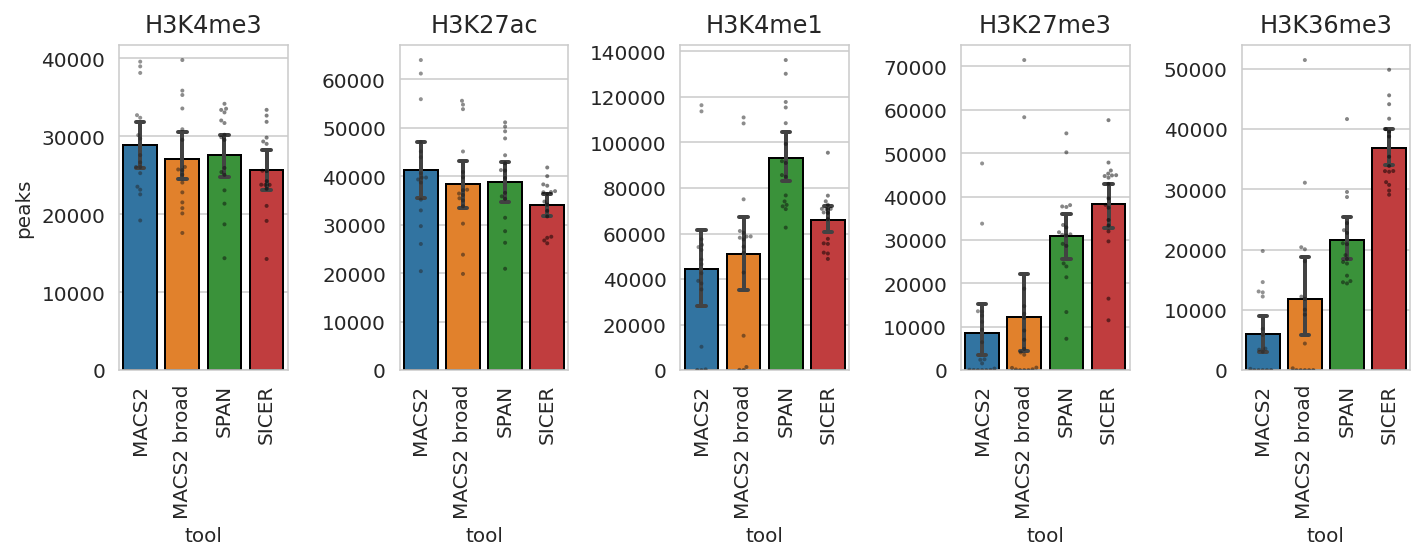

In [109]:
plt.figure(figsize=(10, 4))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, m in enumerate(MODIFICATIONS):
    ax = axs[i]
    sns.barplot(data=df_aligned_control[df_aligned_control['modification'] == m], x='tool', y='peaks',
                # showfliers=False,
                capsize=.2, errwidth=2, edgecolor="black",
                palette=TOOLS_PALETTE,
                order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                ax=ax)
    sns.swarmplot(data=df_aligned_control[df_aligned_control['modification'] == m], x='tool', y='peaks',
                  size=2, palette='dark:black', alpha=0.5,
                  order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'], legend=False,
                  ax=ax)
    ax.xaxis.set_tick_params(rotation=90)
    ax.title.set_text(m)
    if i > 0:
        ax.set_ylabel(None)
    # ax.set_ylim(0, 1)
plt.tight_layout()
# plt.savefig(GSE26320_PATH_HG38 + f'/pics/library_mapped_detailed_all.pdf', bbox_inches='tight', dpi=300)
plt.show()

In [110]:
df_aligned_control_reps = compute_reps_peaks(df_aligned_control, MODIFICATIONS, GSE26320_CELLS + IMMUNE_CELLS)
df_aligned_control_reps['reps_peaks_diff'] = np.fabs(
    (df_aligned_control_reps['peaks1'] - df_aligned_control_reps['peaks2']) /
    (df_aligned_control_reps['peaks1'] + df_aligned_control_reps['peaks2']))
df_aligned_control_reps.sample(5)

,dataset,modification,cell,tool,replicate1,replicate2,peaks1,peaks2,reps_peaks_diff
141,ENCODE,H3K4me3,HMEC,MACS2 broad,rep1,rep2,21521,17600,0.100227
133,ENCODE,H3K4me3,GM12878,MACS2 broad,rep1,rep2,39791,35307,0.059709
2,ENCODE,H3K27ac,GM12878,SICER,rep1,rep2,32865,31704,0.017981
13,ENCODE,H3K27ac,HepG2,MACS2 broad,rep1,rep2,19845,23814,0.090909
9,ENCODE,H3K27ac,HSMM,MACS2 broad,rep1,rep2,45103,53833,0.088239


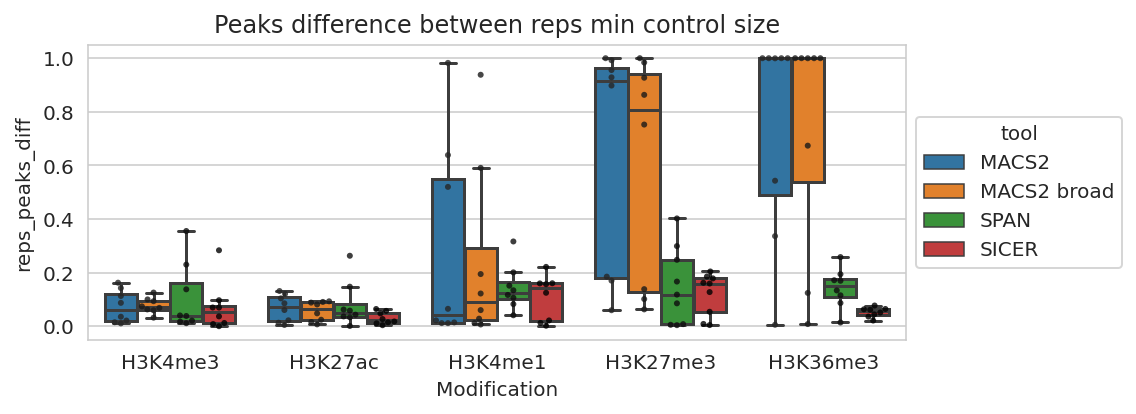

In [111]:
plt.figure(figsize=(8, 3))
ax = plt.axes()
sns.boxplot(data=df_aligned_control_reps, x='modification', hue='tool', y='reps_peaks_diff',
            palette=TOOLS_PALETTE,
            order=MODIFICATIONS,
            hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
            showfliers=False,
            ax=ax)
sns.swarmplot(data=df_aligned_control_reps, x='modification', hue='tool', y='reps_peaks_diff',
              dodge=True, size=3, palette='dark:black', alpha=0.8,
              order=MODIFICATIONS,
              hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'], legend=False,
              ax=ax)
ax.set_title('Peaks difference between reps min control size')
# ax.set_ylabel('Peaks difference')
ax.set_xlabel('Modification')
sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

MACS2


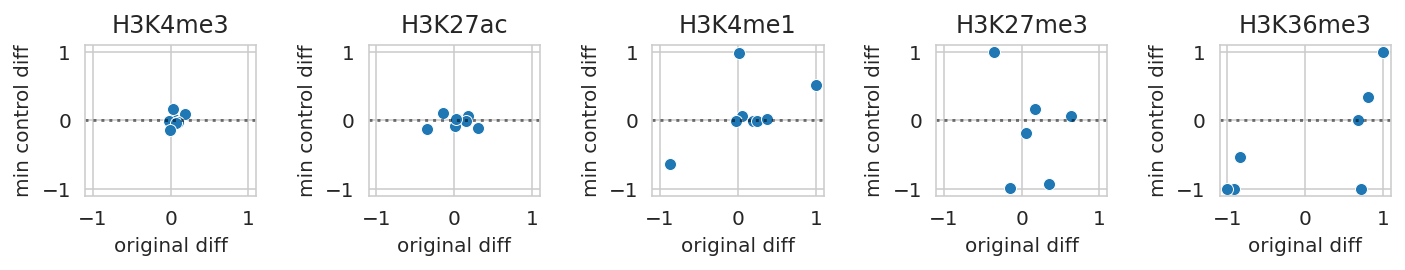

MACS2 broad


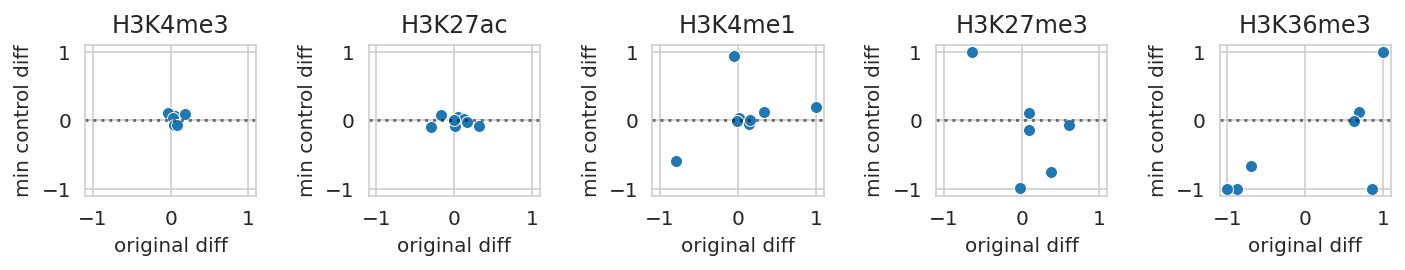

SPAN


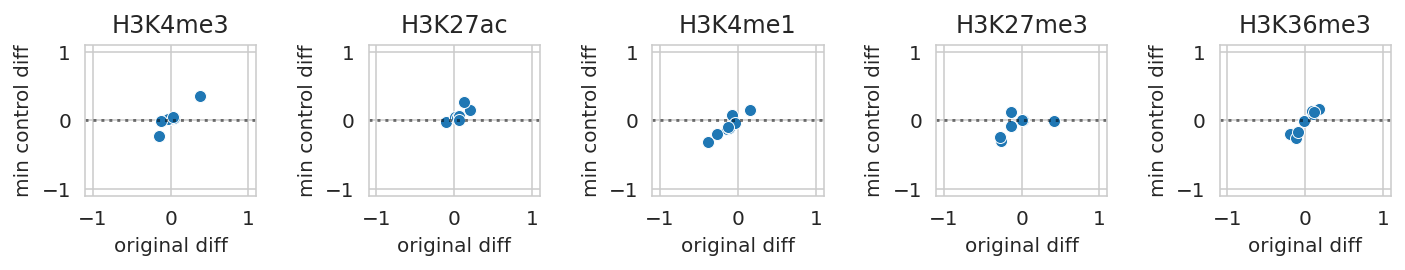

SICER


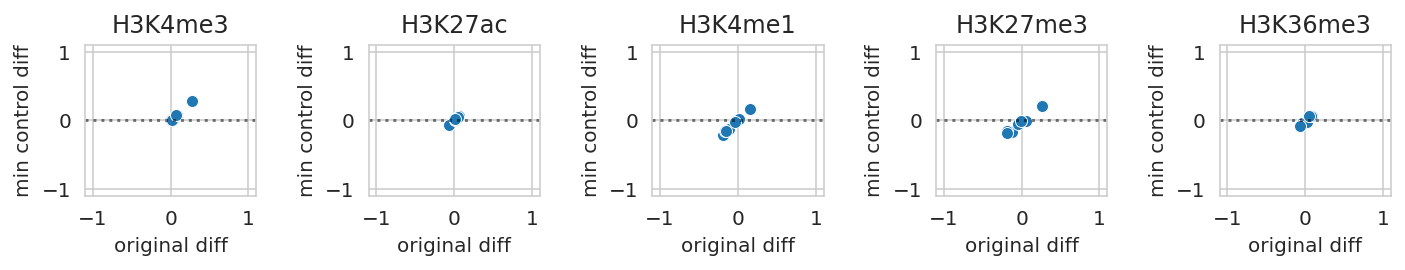

In [113]:
df_aligned_control_reps['min_control_reps_peaks_diff'] = \
    (df_aligned_control_reps['peaks1'] - df_aligned_control_reps['peaks2']) / (
            df_aligned_control_reps['peaks1'] + df_aligned_control_reps['peaks2'])
df_encode_reps['original_reps_peaks_diff'] = \
    (df_encode_reps['peaks1'] - df_encode_reps['peaks2']) / (df_encode_reps['peaks1'] + df_encode_reps['peaks2'])
t = pd.merge(df_aligned_control_reps, df_encode_reps, on=['modification', 'cell', 'tool', 'replicate1', 'replicate2'])

for tool in TOOLS:
    print(tool)
    plt.figure(figsize=(10, 2))
    axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
    for i, m in enumerate(MODIFICATIONS):
        ax = axs[i]
        tt = t[(t['modification'] == m) & (t['tool'] == tool)]
        sns.scatterplot(
            tt, x='original_reps_peaks_diff', y='min_control_reps_peaks_diff',
            ax=ax)
        sns.lineplot(x=[-1.1, 1.1], y=[0, 0], color='black', ax=ax, alpha=0.5, linestyle='dotted')
        ax.title.set_text(m)
        ax.set_xlabel('original diff')
        ax.set_ylabel('min control diff')
        ax.set_xlim(-1.1, 1.1)
        ax.set_ylim(-1.1, 1.1)
    plt.tight_layout()
    plt.show()

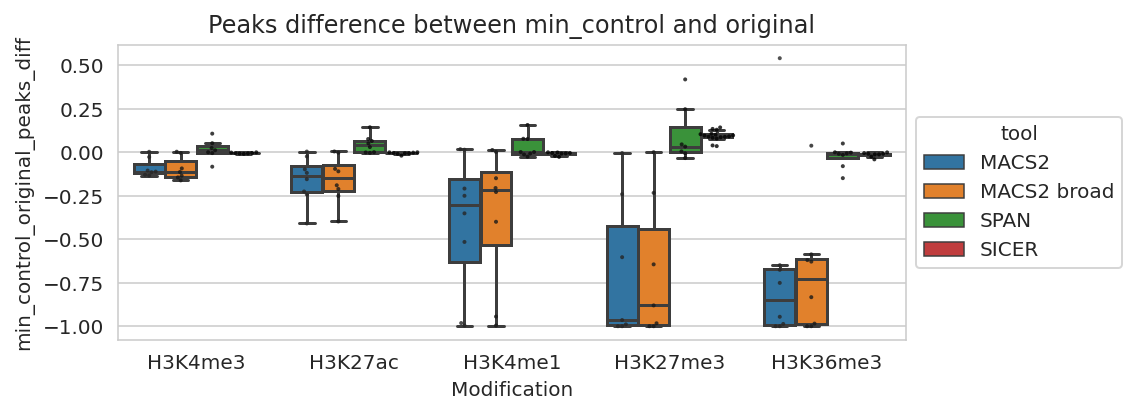

In [114]:
t = pd.merge(df_aligned_control,
             df_peaks_original[['file', 'modification', 'cell', 'replicate', 'peaks', 'tool']],
             on=['modification', 'cell', 'replicate', 'tool'],
             suffixes=('_min_control', '_original'),
             how='inner')
t['min_control_original_peaks_diff'] = [d(p - po, p + po) for _, (p, po) in
                                        t[['peaks_min_control', 'peaks_original']].iterrows()]

plt.figure(figsize=(8, 3))
ax = plt.axes()
sns.boxplot(data=t[t['min_control_original_peaks_diff'] != 0],
            x='modification', hue='tool', y='min_control_original_peaks_diff',
            palette=TOOLS_PALETTE,
            order=MODIFICATIONS,
            hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
            showfliers=False,
            ax=ax)
sns.swarmplot(data=t[t['min_control_original_peaks_diff'] != 0],
              x='modification', hue='tool', y='min_control_original_peaks_diff',
              dodge=True, size=2, palette='dark:black', alpha=0.8,
              order=MODIFICATIONS,
              hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'], legend=False,
              ax=ax)
ax.set_title('Peaks difference between min_control and original')
# ax.set_ylabel('Peaks difference')
ax.set_xlabel('Modification')
sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()